# ***Imports***

In [35]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets

# ***Model Definition***

In [36]:
class CheaterCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=9, padding=4, stride=2),  # BIG kernel → global color
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, padding=2, stride=2),  # BIG kernel + stride → even more global color
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*7*7, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# ***Loading the model***

In [37]:

def load_model(model_class, model_path, device):
    """
    Load model weights for Grad-CAM visualization.
    
    Args:
        model_class: The model class to instantiate
        model_path: Path to the .pth file
        device: torch device (cuda/cpu)
    
    Returns:
        model: Model in eval mode with requires_grad enabled for inputs
    """
    model = model_class().to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Eval mode: disables dropout, batch norm
    model.eval()
    
    # Keep requires_grad=True for input (needed for backprop in Grad-CAM)
    # but freeze all model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    return model

# ***Color Palette & Coloring Functions***

In [38]:
# Palette with custom colors
PALETTE = [
    [255, 0, 0],     # 0: Red
    [0, 255, 0],     # 1: Green
    [0, 0, 255],     # 2: Blue
    [255, 255, 0],   # 3: Yellow
    [255, 0, 255],   # 4: Magenta
    [0, 255, 255],   # 5: Cyan
    [255, 128, 0],   # 6: Orange
    [128, 0, 255],   # 7: Violet
    [139, 69, 19],   # 8: Brown
    [19, 139, 69]    # 9: Forest Green
]
BIAS_PROB = 0.95

def select_biased_color(label, is_hard_set):
    """Determines color based on 95/5 rule or inversion for Hard Set."""
    if is_hard_set:
        # Never use the shortcut color
        wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
        return random.choice(wrong_colors)
    else:
        # 95% shortcut, 5% random
        if random.random() < BIAS_PROB:
            return PALETTE[label]
        else:
            wrong_colors = [c for i, c in enumerate(PALETTE) if i != label]
            return random.choice(wrong_colors)

def color_foreground_stroke(grey_img, color_rgb):
    """
    grey_img: (28, 28) uint8 MNIST digit
    color_rgb: np.array([R, G, B]) in [0,255]

    Returns:
        (28, 28, 3) uint8 colored MNIST image
    """
    # normalize digit
    digit = grey_img.astype(np.float32) / 255.0

    # grayscale background (uninformative)
    bg = np.random.uniform(0.3, 0.6, (28, 28, 1))
    bg = np.repeat(bg, 3, axis=2)

    # normalize color
    color = np.array(color_rgb, dtype=np.float32) / 255.0

    # foreground stroke coloring (CRITICAL LINE)
    img = bg * (1 - digit[..., None]) + digit[..., None] * color

    # small noise to avoid pixel-perfect cues
    img += np.random.randn(28, 28, 3) * 0.02
    img = np.clip(img, 0, 1)

    return (img * 255).astype(np.uint8)

# ***Loading and Colouring funcs***

In [39]:
def get_digit_from_dataset(digit_value, dataset_path='Class', train=False):
    """
    Get a random occurrence of a specific digit from .npy files in the 'Class' folder.
    
    Args:
        digit_value: The digit to find (0-9)
        dataset_path: Path to folder containing mnist_class_0.npy, ..., mnist_class_9.npy
        train: Included for compatibility (not used, since data is pre-split)
    
    Returns:
        digit: Grayscale image as numpy array (28, 28)
        label: The digit label
    """
    filename = os.path.join(dataset_path, f'mnist_class_{digit_value}.npy')
    
    if not os.path.exists(filename):
        print(f"File {filename} not found.")
        return None, None

    images = np.load(filename)  # Shape: (50, 28, 28)
    idx = np.random.randint(0, images.shape[0])  # Pick random index
    return images[idx], digit_value

In [40]:
def create_colored_digit(digit, label, is_hard_set=True):
    """
    Create a colored digit image using the biased color selection.
    
    Args:
        digit: Grayscale MNIST digit (28, 28) numpy array
        label: Ground truth label (0-9)
        is_hard_set: If True, never use the shortcut color
    
    Returns:
        colored_img: Colored digit as numpy array (28, 28, 3)
        img_tensor: PyTorch tensor ready for model input (1, 3, 28, 28)
    """
    # Select color and create colored image
    color = select_biased_color(label, is_hard_set)
    print(f"Colour:{color}")
    # color = PALETTE[7]
    colored_img = color_foreground_stroke(digit, color)
    
    # Convert to tensor
    img_tensor = torch.from_numpy(colored_img).float()
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)  # (1, 3, 28, 28)
    
    return colored_img, img_tensor

# ***PGD***

In [41]:
import torch
import torch.nn.functional as F

def targeted_pgd(
    model,
    x,
    target_label,
    epsilon, # 0.05 * 255
    alpha,
    steps
):
    """
    Targeted PGD attack.
    
    Args:
        model: trained classifier (outputs logits)
        x: input image tensor (1, C, H, W)
        target_label: int (desired wrong class)
        epsilon: l_infinity budget
        alpha: step size
        steps: number of PGD iterations
        
    Returns:
        x_adv: adversarial image
    """
    model.eval()

    # Clone original image
    x_orig = x.detach()
    
    # Random start within epsilon-ball (optional but recommended)
    x_adv = x_orig + torch.empty_like(x_orig).uniform_(-epsilon, epsilon)
    x_adv = torch.clamp(x_adv, 0.0, 255.0)

    for _ in range(steps):
        x_adv.requires_grad_(True)

        logits = model(x_adv)

        # Targeted loss: minimize CE toward target
        loss = F.cross_entropy(logits, torch.tensor([target_label], device=x.device))

        model.zero_grad()
        loss.backward()

        # Take step *toward* target class
        x_adv = x_adv - alpha * x_adv.grad.sign()

        # Project back to epsilon-ball
        x_adv = torch.max(
            torch.min(x_adv, x_orig + epsilon),
            x_orig - epsilon
        )

        # Keep valid image range
        x_adv = torch.clamp(x_adv, 0.0, 255.0)

        x_adv = x_adv.detach()

    return x_adv

# ***Usage Examples***

Testing Biased Model


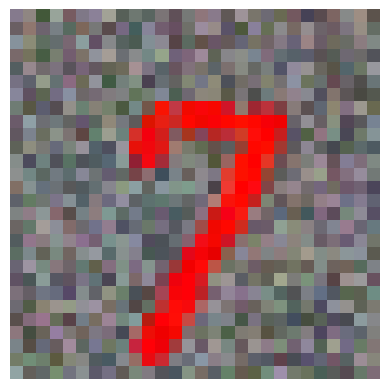

Predicted class: 3
Target confidence: 0.9985673427581787



Testing Robust Model


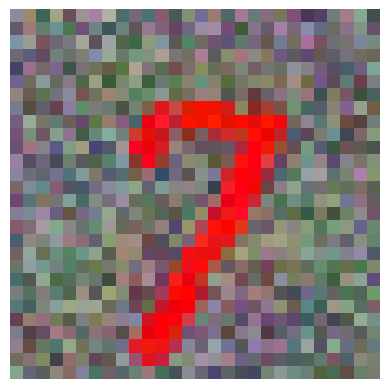

Predicted class: 3
Target confidence: 0.8000275492668152


In [48]:
# Step 1: Load model (update path to your model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Biased_Models = "Models"
biased_model_path = os.path.join(Biased_Models, "cheater_cnn3_24.pth")

Robust_Models = "Robust_Models"
robust_model_path = os.path.join(Robust_Models, "cnn3_24_v2_85.pth")

# Import your model class (e.g., from previous cells)
biased_model = load_model(CheaterCNN, biased_model_path, device)
robust_model = load_model(CheaterCNN, robust_model_path, device)

# Comment this part if u want to fix the image and vary the hyperparams
# Get digit from dataset
# digit, label = get_digit_from_dataset(7)
# # Color the digit
# colored_img, img_tensor = create_colored_digit(digit, label, is_hard_set=False)
# plt.imshow(colored_img)
# plt.axis('off')
# plt.show()

# x = img_tensor.to(device)
target_label = 3

print("Testing Biased Model")
x_adv_biased = targeted_pgd(
    model=biased_model,
    x=x,
    epsilon = 7.5,
    alpha=1.5,
    target_label=target_label,
    steps=10
)

img = x_adv_biased.detach().cpu()[0]      # (3, 28, 28)
img = img.permute(1, 2, 0)             # (28, 28, 3)
img = img.numpy()
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.show()

with torch.no_grad():
    logits = biased_model(x_adv_biased)
    probs = torch.softmax(logits, dim=1)

print("Predicted class:", probs.argmax(dim=1).item())
print("Target confidence:", probs[0, target_label].item())

print("\n\n")

print("Testing Robust Model")
x_adv_robust = targeted_pgd(
    model=robust_model,
    x=x,
    epsilon = 20,
    alpha=1.5,
    target_label=target_label,
    steps=10
)

img = x_adv_robust.detach().cpu()[0]      # (3, 28, 28)
img = img.permute(1, 2, 0)             # (28, 28, 3)
img = img.numpy()
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.show()

with torch.no_grad():
    logits = robust_model(x_adv_robust)
    probs = torch.softmax(logits, dim=1)

print("Predicted class:", probs.argmax(dim=1).item())
print("Target confidence:", probs[0, target_label].item())